# Simulating Cell Operation with "pET19KT [MaSp2]32.xdna"

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Define ME-Model Solve Functions

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

## 4. Create the pET19KT [MaSp2]32 Transcription Reaction

Complete the steps necessary to create the MaSp2 Transcription Reaction

In [4]:
locus_id = 'MaSp2'
left_pos =  None
right_pos = None
seq = 'ATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCCTGGACAACAAGGGCCTAGTGGTCCTGGTTCTGCAGCGGCAGCCGCTGCGGCAGCTGGTCCGGGACAGCAAGGACCCGGTGGATACGGTCCCGGTCAGCAGGGACCTGGCGGTTACGGACCCGGACAACAGGGTCCATCTGGTCCTGGTAGCGCAGCCGCAGCAGCAGCGGCTGCAGGTCCAGGACAACAAGGTCCTGGTGGGTATGGTCCAGGGCAGCAAGGTCCGAGTGGTCCAGGCTCTGCGGCAGCGGCAGCAGCAGCAGCGGGACCTGGTCAACAGGGTCCAGGGGGATATGGCCCAGGTCAGCAAGGACCGGGTGGCTATGGGCCAGGTCAACAAGGCCCTAGCGGTCCGGGATCTGCCGCAGCTGCAGCGGCAGCGGCAGGTCCTGGCGGTTATGGACCAGGTCAGCAGGGTCCCGGTGGCTACGGTCCCGGACAACAAGGCCCAGGGGGTTACGGACCTGGCCAGCAAGGTCCTTCTGGACCGGGAAGCGCTGCAGCCGCAGCAGCTGCAGCCGGTCCAGGCCAGCAAGGGCCTGGGGGTTACGGTCCGGGTCAGCAAGGCCCAGGCGGATACGGTCCAGGACAACAGGGACCAAGTGGTCCGGGATCAGCAGCCGCTGCCGCAGCGGCAGCCGGTCCCGGTCAACAAGGACCTGGTGGCTACGGTCCTGGGCAACAGGGTCCTAGCGGTCCAGGGTCAGCAGCAGCAGCCGCAGCTGCAGCATCCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCCTGGACAACAAGGGCCTAGTGGTCCTGGTTCTGCAGCGGCAGCCGCTGCGGCAGCTGGTCCGGGACAGCAAGGACCCGGTGGATACGGTCCCGGTCAGCAGGGACCTGGCGGTTACGGACCCGGACAACAGGGTCCATCTGGTCCTGGTAGCGCAGCCGCAGCAGCAGCGGCTGCAGGTCCAGGACAACAAGGTCCTGGTGGGTATGGTCCAGGGCAGCAAGGTCCGAGTGGTCCAGGCTCTGCGGCAGCGGCAGCAGCAGCAGCGGGACCTGGTCAACAGGGTCCAGGGGGATATGGCCCAGGTCAGCAAGGACCGGGTGGCTATGGGCCAGGTCAACAAGGCCCTAGCGGTCCGGGATCTGCCGCAGCTGCAGCGGCAGCGGCAGGTCCTGGCGGTTATGGACCAGGTCAGCAGGGTCCCGGTGGCTACGGTCCCGGACAACAAGGCCCAGGGGGTTACGGACCTGGCCAGCAAGGTCCTTCTGGACCGGGAAGCGCTGCAGCCGCAGCAGCTGCAGCCGGTCCAGGCCAGCAAGGGCCTGGGGGTTACGGTCCGGGTCAGCAAGGCCCAGGCGGATACGGTCCAGGACAACAGGGACCAAGTGGTCCGGGATCAGCAGCCGCTGCCGCAGCGGCAGCCGGTCCCGGTCAACAAGGACCTGGTGGCTACGGTCCTGGGCAACAGGGTCCTAGCGGTCCAGGGTCAGCAGCAGCAGCCGCAGCTGCAGCATCCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCCTGGACAACAAGGGCCTAGTGGTCCTGGTTCTGCAGCGGCAGCCGCTGCGGCAGCTGGTCCGGGACAGCAAGGACCCGGTGGATACGGTCCCGGTCAGCAGGGACCTGGCGGTTACGGACCCGGACAACAGGGTCCATCTGGTCCTGGTAGCGCAGCCGCAGCAGCAGCGGCTGCAGGTCCAGGACAACAAGGTCCTGGTGGGTATGGTCCAGGGCAGCAAGGTCCGAGTGGTCCAGGCTCTGCGGCAGCGGCAGCAGCAGCAGCGGGACCTGGTCAACAGGGTCCAGGGGGATATGGCCCAGGTCAGCAAGGACCGGGTGGCTATGGGCCAGGTCAACAAGGCCCTAGCGGTCCGGGATCTGCCGCAGCTGCAGCGGCAGCGGCAGGTCCTGGCGGTTATGGACCAGGTCAGCAGGGTCCCGGTGGCTACGGTCCCGGACAACAAGGCCCAGGGGGTTACGGACCTGGCCAGCAAGGTCCTTCTGGACCGGGAAGCGCTGCAGCCGCAGCAGCTGCAGCCGGTCCAGGCCAGCAAGGGCCTGGGGGTTACGGTCCGGGTCAGCAAGGCCCAGGCGGATACGGTCCAGGACAACAGGGACCAAGTGGTCCGGGATCAGCAGCCGCTGCCGCAGCGGCAGCCGGTCCCGGTCAACAAGGACCTGGTGGCTACGGTCCTGGGCAACAGGGTCCTAGCGGTCCAGGGTCAGCAGCAGCAGCCGCAGCTGCAGCATCCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCCTGGACAACAAGGGCCTAGTGGTCCTGGTTCTGCAGCGGCAGCCGCTGCGGCAGCTGGTCCGGGACAGCAAGGACCCGGTGGATACGGTCCCGGTCAGCAGGGACCTGGCGGTTACGGACCCGGACAACAGGGTCCATCTGGTCCTGGTAGCGCAGCCGCAGCAGCAGCGGCTGCAGGTCCAGGACAACAAGGTCCTGGTGGGTATGGTCCAGGGCAGCAAGGTCCGAGTGGTCCAGGCTCTGCGGCAGCGGCAGCAGCAGCAGCGGGACCTGGTCAACAGGGTCCAGGGGGATATGGCCCAGGTCAGCAAGGACCGGGTGGCTATGGGCCAGGTCAACAAGGCCCTAGCGGTCCGGGATCTGCCGCAGCTGCAGCGGCAGCGGCAGGTCCTGGCGGTTATGGACCAGGTCAGCAGGGTCCCGGTGGCTACGGTCCCGGACAACAAGGCCCAGGGGGTTACGGACCTGGCCAGCAAGGTCCTTCTGGACCGGGAAGCGCTGCAGCCGCAGCAGCTGCAGCCGGTCCAGGCCAGCAAGGGCCTGGGGGTTACGGTCCGGGTCAGCAAGGCCCAGGCGGATACGGTCCAGGACAACAGGGACCAAGTGGTCCGGGATCAGCAGCCGCTGCCGCAGCGGCAGCCGGTCCCGGTCAACAAGGACCTGGTGGCTACGGTCCTGGGCAACAGGGTCCTAGCGGTCCAGGGTCAGCAGCAGCAGCCGCAGCTGCAGCATCCGGAGGG'
#seq = 'AAGTTGCATATGACTGGTCCTGGCCAGCAGGGCCCTGGCGGATACGGCCCCGGGCAGCAGGGCCCCAGTGGCCCCGGCAGTGCAGCAGCCGCCGCCGCTGCCGCGGGGCCAGGGCAGCAGGGGCCGGGTGGCTATGGCCCTGGGCAGCAAGGTCCAGGCGGTTATGGTCCGGGGCAACAGGGACCCAGCGGCCCTGGTAGTGCAGCGGCAGCGGCTGCCGCTGCCGGGCCCGGAGGTTATGGGCCTGGGCAACAGGGTCCAGGCGGGTATGGCCCTGGGCAACAAGGACCAGGCGGGTACGGCCCAGGCCAACAGGGGCCTAGCGGACCCGGTTCCGCCGCAGCCGCGGCGGCAGCCGCAGGACCTGGCCAACAGGGGCCCGGTGGGTACGGCCCCGGGCAGCAGGGACCTGGGGGGTATGGGCCGGGTCAGCAGGGCCCAAGTGGACCAGGCAGCGCCGCAGCGGCCGCCGCAGCCGCTGGACCTGGCCAACAGGGACCGGGCGGGTATGGGCCGGGCCAGCAGGGGCCTTCTGGGCCTGGTTCGGCCGCGGCGGCGGCCGCGGCTGCAGGACCTGGACAGCAAGGTCCGGGCGGTTATGGACCAGGCCAGCAGGGCCCCGGCGGGTATGGGCCCGGCCAGCAGGGTCCATCTGGGCCGGGAAGTGCGGCTGCGGCGGCGGCTGCCGCTGGCCCTGGCGGATACGGCCCAGGGCAGCAGGGGCCTGGGGGCTATGGGCCCGGTCAACAGGGACCGGGGGGATACGGCCCGGGGCAACAAGGGCCTAGTGGCCCAGGTTCGGCAGCTGCCGCGGCTGCCGCAGCCGGGCCAGGTCAGCAGGGACCGGGGGGGTATGGTCCTGGTCAACAGGGACCGGGAGGCTATGGCCCAGGTCAGCAGGGACCCTCGGGCCCTGGGAGTGCCGCGGCTGCCGCCGCTGCTGCAGGTCCAGGCCAACAGGGTCCTGGGGGATACGGACCTGGGCAACAGGGCCCTTCGGGACCTGGTAGCGCTGCCGCGGCGGCAGCGGCAGCATCGGGGGGAGAT'
#seq = 'AAGCTTCATATGACAGGCCCCGGGCAGCAAGGTCCCGGCGGATACGGGCCGGGTCAGCAAGGGCCATCCGGTCCCGGGTCTGCCGCTGCTGCTGCAGCTGCAGCTGGACCCGGCCAGCAGGGGCCTGGAGGTTATGGTCCCGGTCAACAAGGCCCCGGAGGGTATGGGCCAGGGCAACAAGGACCATCTGGTCCAGGGAGTGCTGCAGCGGCCGCTGCTGCAGCTGGCCCAGGGGGTTATGGACCTGGGCAACAGGGGCCGGGCGGGTACGGGCCTGGACAGCAAGGACCCGGAGGCTATGGCCCGGGCCAACAGGGGCCTAGCGGGCCCGGATCCGCGGCCGCTGCAGCCGCAGCGGCCGGTCCGGGCCAGCAAGGTCCTGGGGGCTATGGACCGGGGCAACAAGGACCTGGCGGATACGGCCCGGGTCAGCAAGGCCCGTCAGGTCCAGGCTCTGCAGCCGCTGCTGCTGCTGCCGCGGGACCTGGCCAGCAGGGACCGGGCGGATATGGTCCCGGGCAACAGGGACCCAGCGGGCCGGGCTCCGCGGCAGCCGCGGCCGCGGCCGCAGGGCCCGGCCAACAGGGACCAGGGGGTTACGGGCCCGGACAACAAGGTCCAGGAGGGTATGGTCCCGGCCAGCAAGGTCCATCTGGTCCAGGATCGGCGGCGGCAGCCGCTGCGGCGGCGGGACCTGGTGGTTATGGACCTGGACAGCAGGGCCCGGGCGGCTACGGACCCGGACAACAGGGTCCTGGTGGGTACGGACCGGGGCAACAGGGCCCGTCTGGGCCAGGCTCGGCCGCTGCAGCAGCGGCCGCCGCCGGCCCGGGGCAACAGGGGCCGGGGGGATATGGTCCGGGCCAGCAGGGTCCAGGTGGTTACGGTCCCGGCCAACAGGGGCCTAGTGGGCCGGGGTCTGCAGCGGCAGCGGCGGCGGCTGCCGGCCCTGGTCAGCAGGGGCCGGGCGGCTATGGCCCCGGCCAACAAGGTCCCTCGGGCCCAGGCTCAGCGGCGGCGGCGGCAGCAGCAGCTTCCGGAGGCGACAAATTACATATGACGGGACCAGGACAGCAGGGCCCCGGTGGGTACGGCCCAGGTCAACAGGGACCAAGCGGACCAGGCTCTGCAGCTGCCGCCGCAGCAGCGGCGGGGCCGGGTCAGCAAGGTCCTGGAGGGTACGGTCCAGGACAACAAGGACCAGGTGGCTATGGACCTGGACAGCAAGGACCGTCGGGACCCGGCTCTGCCGCCGCCGCGGCCGCGGCGGCCGGTCCTGGAGGCTACGGCCCTGGACAGCAGGGCCCCGGGGGGTATGGTCCTGGACAACAAGGCCCCGGCGGCTATGGTCCAGGTCAGCAAGGCCCAAGTGGTCCTGGTTCGGCGGCAGCTGCAGCGGCTGCGGCTGGGCCGGGACAACAGGGTCCAGGAGGATATGGTCCTGGGCAGCAAGGGCCCGGTGGCTACGGACCAGGCCAACAAGGTCCATCAGGTCCAGGTAGTGCAGCAGCTGCGGCAGCAGCCGCAGGTCCAGGGCAACAGGGCCCAGGCGGGTACGGGCCCGGCCAGCAGGGTCCTAGCGGGCCCGGGAGCGCAGCCGCCGCCGCAGCCGCGGCCGGCCCGGGACAGCAAGGCCCTGGAGGATACGGACCAGGGCAACAAGGGCCGGGTGGTTATGGTCCTGGACAACAAGGACCTTCCGGCCCTGGCAGTGCCGCGGCAGCAGCAGCGGCGGCTGGGCCTGGTGGTTATGGTCCGGGCCAGCAGGGGCCCGGTGGTTACGGCCCCGGTCAGCAGGGGCCTGGAGGCTATGGACCCGGACAGCAAGGCCCTTCAGGACCTGGATCCGCAGCTGCCGCTGCTGCCGCAGCTGGCCCAGGCCAACAAGGCCCGGGCGGGTACGGTCCCGGACAACAAGGTCCGGGAGGTTACGGCCCCGGACAACAAGGTCCATCAGGGCCTGGCTCGGCTGCGGCAGCGGCAGCTGCCGCTGGACCTGGACAACAAGGACCAGGGGGCTATGGCCCAGGGCAGCAGGGGCCTAGCGGGCCGGGGTCTGCAGCCGCAGCGGCCGCGGCTGCATCGGGAGGCGATAAGCTCCATATGACTGGGCCGGGCCAACAGGGCCCCGGTGGTTACGGCCCGGGCCAACAAGGTCCATCAGGGCCTGGCTCGGCTGCAGCGGCTGCTGCTGCAGCTGGCCCGGGGCAACAGGGTCCAGGGGGGTATGGCCCAGGACAACAAGGCCCTGGCGGTTATGGGCCAGGGCAACAGGGTCCCAGTGGACCCGGCTCTGCCGCTGCCGCTGCGGCGGCTGCAGGTCCAGGAGGTTATGGTCCGGGCCAGCAGGGACCCGGCGGCTACGGTCCCGGGCAGCAAGGGCCTGGCGGGTACGGACCCGGTCAGCAGGGCCCGTCCGGCCCGGGTAGCGCTGCCGCTGCCGCGGCGGCAGCGGGACCGGGTCAACAAGGCCCGGGTGGATATGGACCGGGTCAGCAAGGTCCAGGTGGTTACGGTCCGGGACAACAGGGGCCCAGTGGACCGGGATCAGCGGCTGCGGCGGCCGCAGCAGCCGGCCCGGGGCAGCAAGGTCCAGGAGGCTACGGACCAGGCCAACAAGGTCCCAGCGGTCCTGGATCGGCTGCAGCGGCGGCCGCCGCTGCCGGCCCCGGGCAACAAGGACCTGGTGGATACGGTCCGGGCCAGCAGGGTCCTGGCGGTTATGGACCAGGTCAGCAAGGACCAAGTGGTCCGGGCTCAGCCGCAGCCGCCGCCGCAGCAGCGGGGCCCGGTGGGTATGGACCGGGTCAACAAGGACCGGGTGGGTATGGGCCAGGCCAACAGGGGCCGGGTGGTTACGGACCTGGACAGCAAGGCCCTTCCGGCCCAGGCTCGGCGGCTGCAGCAGCCGCGGCTGCAGGTCCTGGACAGCAGGGGCCTGGAGGTTATGGTCCAGGGCAGCAGGGACCCGGTGGCTACGGTCCAGGTCAACAAGGCCCGAGTGGGCCAGGGAGTGCTGCTGCTGCTGCTGCTGCCGCGGGCCCCGGCCAACAGGGCCCTGGAGGCTATGGTCCGGGCCAACAGGGCCCATCGGGTCCGGGATCGGCGGCAGCTGCCGCGGCAGCAGCTAGTGGCGGAGACAAGTTACACATGACTGGCCCTGGACAGCAAGGGCCCGGCGGCTATGGACCCGGCCAGCAGGGTCCATCAGGACCAGGCTCAGCGGCAGCTGCTGCCGCGGCAGCAGGTCCTGGGCAACAAGGCCCAGGCGGTTACGGGCCAGGCCAGCAGGGGCCTGGAGGCTACGGACCTGGTCAACAAGGCCCGTCAGGACCGGGATCGGCTGCAGCGGCGGCAGCAGCGGCCGGCCCAGGCGGATATGGGCCTGGACAACAGGGTCCTGGGGGTTATGGACCTGGACAGCAGGGGCCTGGCGGCTACGGTCCTGGCCAACAAGGCCCTAGTGGACCTGGTTCAGCCGCTGCGGCAGCTGCGGCCGCTGGTCCGGGGCAGCAAGGCCCCGGTGGATATGGCCCAGGTCAACAAGGACCAGGTGGGTACGGCCCGGGACAACAGGGCCCTAGCGGTCCAGGGTCGGCAGCCGCAGCGGCCGCTGCCGCCGGCCCAGGACAACAGGGCCCCGGAGGTTATGGTCCTGGGCAACAGGGACCTTCAGGACCTGGGTCGGCCGCGGCCGCGGCCGCGGCTGCGGGACCAGGGCAGCAAGGTCCTGGGGGCTATGGACCGGGCCAGCAAGGCCCTGGTGGCTATGGTCCAGGGCAACAGGGACCAAGCGGACCTGGGAGCGCCGCCGCGGCCGCTGCGGCCGCCGGCCCCGGGGGTTACGGGCCCGGACAACAGGGTCCGGGAGGCTATGGGCCAGGGCAGCAAGGGCCCGGAGGTTACGGGCCGGGGCAACAGGGACCATCAGGACCTGGTTCGGCAGCAGCAGCGGCGGCGGCAGCGGGTCCCGGTCAGCAGGGTCCCGGTGGCTACGGACCGGGACAGCAAGGTCCCGGAGGGTATGGTCCCGGGCAGCAGGGTCCATCGGGTCCAGGGTCTGCCGCTGCAGCTGCGGCTGCTGCGGGGCCAGGGCAGCAGGGTCCAGGTGGTTATGGACCGGGACAGCAGGGGCCATCGGGCCCGGGTTCGGCAGCCGCGGCAGCGGCCGCGGCGTCGGGTGGCGAT'
strand = None
rna_type = 'mRNA'

building.create_transcribed_gene(me, locus_id, rna_type, seq)
building.add_transcription_reaction(me, 'TU_MaSp2', {'MaSp2'}, seq)
print(me.reactions.transcription_TU_MaSp2.reaction)
me.reactions.transcription_TU_MaSp2.update()

549 atp_c + 1570 ctp_c + 1218 gtp_c + 767 utp_c --> RNA_MaSp2 + 1311.0214523240002 mRNA_biomass + 4104 ppi_c


/source/cobrame/cobrame/core/reaction.py:852 UserWarning: RNA Polymerase () not found


###  Add the RNAP to the MaSp2 Transcription Reaction

In [5]:
me.reactions.transcription_TU_MaSp2.transcription_data.RNA_polymerase = 'RNAP70-CPLX'
me.reactions.transcription_TU_MaSp2.update()

List the transcription data ("transcription_data") associated with the MaSp2 transcription reaction ("transcription_TU_MaSp2").

In [6]:
rxn = me.reactions.transcription_TU_MaSp2
data = rxn.transcription_data
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,TU_MaSp2
_model,iJL1678b-ME
_parent_reactions,{'transcription_TU_MaSp2'}
nucleotide_sequence,ATGACCGGTCCGGGTCAGCAGGGTCCGGGTGGTTATGGTCCTGGCCAGCAGGGACCGAGCGGTCCGGGTAGTGCAGCAGCAGCTGCAGCAGCCGCAGGCCCTGGTCAGCAAGGCCCTGGTGGATATGGACCAGGCCAACAGGGTCCTGGCGGATACGGTCCTGGTCAACAAGGTCCGTCAGGTCCGGGTTCAGCCGCAGCGGCTGCTGCCGCAGCAGGTCCAGGTGGCTACGGACCGGGTCAACAGGGACCCGGTGGGTACGGACCAGGACAGCAAGGGCCAGGCGGTTATGGCCC...
RNA_products,{'RNA_MaSp2'}
RNA_polymerase,RNAP70-CPLX
subreactions,"defaultdict(<class 'int'>, {})"


List the attributes of the MaSp2 transcription reaction.

In [7]:
rxn = me.reactions.transcription_TU_MaSp2
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,transcription_TU_MaSp2
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,"{<RNAP RNAP70-CPLX at 0x7f9525bbe320>: -0.0196124982794219*mu - 0.00767829307639367, <TranscribedGene RNA_MaSp2 at 0x7f9525ce8f28>: 1, <Metabolite utp_c at 0x7f9525bbeda0>: -767, <Metabolite atp_c at 0x7f9525bbe940>: -549, <Metabolite ctp_c at 0x7f9525bbee80>: -1570, <Metabolite gtp_c at 0x7f952..."
_model,iJL1678b-ME
_objective_coefficient,0.0


List the complete reaction associated with the MaSp2 transcription reaction.

In [8]:
me.reactions.get_by_id('transcription_TU_MaSp2').reaction

'0.0196124982794219*mu + 0.00767829307639367 RNAP70-CPLX + 549 atp_c + 1570 ctp_c + 1218 gtp_c + 767 utp_c --> RNA_MaSp2 + 1311.0214523240002 mRNA_biomass + 4104 ppi_c'

List the RNAP associated with the MaSp2 transcription reaction

In [9]:
me.reactions.transcription_TU_MaSp2.transcription_data.RNA_polymerase

'RNAP70-CPLX'

## 5. Create the MaSp2 Translation Reaction

Complete all the steps necessary to create the MaSp2 Translation Reaction

### Storing information about a translation reaction

In [10]:
data = cobrame.TranslationData('MaSp2', me, 'RNA_MaSp2', 'protein_MaSp2')
data.nucleotide_sequence = seq

### Create translation reaction

By associating the TranslationReaction with its corresponding TranslationData object and running the update function, COBRAme will create a translation reaction for the nucleotide sequence given based on the organisms codon table and prespecified translation machinery.

In [11]:
rxn = cobrame.TranslationReaction('translation_MaSp2')
rxn.translation_data = data
me.add_reaction(rxn)

### Updating the translation reaction

Note that this process does not include the ribosome in the reaction.

In [12]:
rxn.update()
print(rxn.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 6.13480109739369*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 506 gly_c + 7.84095134723271*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 236 pro__L_c + 0.0196124982794219*mu + 0.00767829307639367 ribosome + 76 ser__L_c + thr__L_c + 68 tyr__L_c --> 6.13480109739369*(mu + 0.3915)/mu adp_c + 3.28345679012346*(mu + 0.3915)/mu amp_c + 9.38984910836763*(mu + 0.3915)/mu cmp_c + 7.28460905349794*(mu + 0.3915)/mu gmp_c + 1367.0 - 6.13480109739369*(mu + 0.3915)/mu h2o_c + 6.13480109739369*(mu + 0.3915)/mu h_c + 6.13480109739369*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 114.82236754 protein_biomass + 4.58727023319616*(mu + 0.3915)/mu ump_c


In [13]:
len(seq)/3

1368.0

### Incorporate the ribosome

Add the ribosome to the reaction.

In [14]:
ribosome = cobrame.Ribosome('ribosome')
me.add_metabolites([ribosome])
me.reactions.translation_MaSp2.update()
print(me.reactions.translation_MaSp2.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 6.13480109739369*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 506 gly_c + 7.84095134723271*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 236 pro__L_c + 0.0196124982794219*mu + 0.00767829307639367 ribosome + 76 ser__L_c + thr__L_c + 68 tyr__L_c --> 6.13480109739369*(mu + 0.3915)/mu adp_c + 3.28345679012346*(mu + 0.3915)/mu amp_c + 9.38984910836763*(mu + 0.3915)/mu cmp_c + 7.28460905349794*(mu + 0.3915)/mu gmp_c + 1367.0 - 6.13480109739369*(mu + 0.3915)/mu h2o_c + 6.13480109739369*(mu + 0.3915)/mu h_c + 6.13480109739369*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 114.82236754 protein_biomass + 4.58727023319616*(mu + 0.3915)/mu ump_c


### Add Subreactions to the MaSp2 model

Create the subreactions that represent elongation, initiation and termination

In [15]:
elongation = ['FusA_mono_elongation', 'Tuf_gtp_regeneration']
initiation = ['Translation_gtp_initiation_factor_InfB', 'Translation_initiation_factor_InfA', 
              'Translation_initiation_factor_InfC', 'fmet_addition_at_START', 'peptide_deformylase_processing', 
              'peptide_chain_release', 'ribosome_recycler']
termination = {'UGA':'PrfB_mono'}
me.process_data.get_by_id('MaSp2').add_elongation_subreactions(elongation_subreactions=set(elongation))
me.process_data.get_by_id('MaSp2').add_initiation_subreactions(start_codons=set(['AUG']), start_subreactions=set(initiation))
me.process_data.get_by_id('MaSp2').add_termination_subreactions(translation_terminator_dict=termination)
#me.reactions.translation_MaSp2.update(verbose=False)

/source/cobrame/cobrame/core/processdata.py:896 UserWarning: No termination enzyme for RNA_MaSp2


List the subreactions associated with MaSp2 translation reaction stored in the ProcessData.

In [16]:
me.process_data.get_by_id('MaSp2').subreactions

defaultdict(int,
            {'FusA_mono_elongation': 1367.0,
             'Tuf_gtp_regeneration': 1367.0,
             'thr_addition_at_ACC': 1,
             'gly_addition_at_GGU': 252,
             'pro_addition_at_CCG': 56,
             'gln_addition_at_CAG': 88,
             'tyr_addition_at_UAU': 28,
             'pro_addition_at_CCU': 80,
             'gly_addition_at_GGC': 84,
             'gly_addition_at_GGA': 121,
             'ser_addition_at_AGC': 20,
             'ser_addition_at_AGU': 16,
             'ala_addition_at_GCA': 156,
             'ala_addition_at_GCU': 44,
             'ala_addition_at_GCC': 48,
             'gln_addition_at_CAA': 104,
             'pro_addition_at_CCA': 72,
             'tyr_addition_at_UAC': 40,
             'ser_addition_at_UCA': 16,
             'ala_addition_at_GCG': 40,
             'pro_addition_at_CCC': 28,
             'gly_addition_at_GGG': 48,
             'ser_addition_at_UCU': 20,
             'ser_addition_at_UCC': 4,
           

List the subreactions generated from the nucleatide sequence that are stored in the ProcessData.

In [17]:
me.process_data.get_by_id('MaSp2').subreactions_from_sequence

{'thr_addition_at_ACC': 1,
 'gly_addition_at_GGU': 252,
 'pro_addition_at_CCG': 56,
 'gln_addition_at_CAG': 88,
 'tyr_addition_at_UAU': 28,
 'pro_addition_at_CCU': 80,
 'gly_addition_at_GGC': 84,
 'gly_addition_at_GGA': 121,
 'ser_addition_at_AGC': 20,
 'ser_addition_at_AGU': 16,
 'ala_addition_at_GCA': 156,
 'ala_addition_at_GCU': 44,
 'ala_addition_at_GCC': 48,
 'gln_addition_at_CAA': 104,
 'pro_addition_at_CCA': 72,
 'tyr_addition_at_UAC': 40,
 'ser_addition_at_UCA': 16,
 'ala_addition_at_GCG': 40,
 'pro_addition_at_CCC': 28,
 'gly_addition_at_GGG': 48,
 'ser_addition_at_UCU': 20,
 'ser_addition_at_UCC': 4}

### Updating the MaSp2 translation reaction

In [18]:
translation_subreactions = me.process_data.MaSp2.subreactions_from_sequence
print("Before adding tRNA subreaction")
print("------------------------------")
print(me.reactions.translation_MaSp2.reaction)
print("")
# Link tranlation_data to subreactions and update
for subreaction, value in translation_subreactions.items():
    me.process_data.MaSp2.subreactions[subreaction] = value
me.reactions.translation_MaSp2.update(verbose=False)
print("After adding tRNA subreaction")
print("-----------------------------")
print(me.reactions.translation_MaSp2.reaction)

Before adding tRNA subreaction
------------------------------
0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp2 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 288 ala__L_c + 6.13480109739369*(mu + 0.3915)/mu atp_c + 192 gln__L_c + 506 gly_c + 7.84095134723271*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 236 pro__L_c + 0.0196124982794219*mu + 0.00767829307639367 ribosome + 76 ser__L_c + thr__L_c + 68 tyr__L_c --> 6.13480109739369*(mu + 0.3915)/mu adp_c + 3.28345679012346*(mu + 0.3915)/mu amp_c + 9.38984910836763*(mu + 0.3915)/mu cmp_c + 7.28460905349794*(mu + 0.3915)/mu gmp_c + 1367.0 - 6.13480109739369*(mu + 0.3915)/mu h2o_c + 6.13480109739369*(mu + 0.3915)/mu h_c + 6.13480109739369*(mu + 0.3915)/mu pi_c + protein_MaSp2 + 114.82236754 protein_biomass + 4.58727023319616*(mu + 0.3915)/mu ump_c

After adding tRNA subreaction
-----------------------------
10fthf_c + 2.72438972852433e-7*mu Def_mono_mod_1:fe2 + 1.80324164444648e-7

List the reactants associated with the MaSp2 translation reaction. In this list all the subreactions should be listed.

In [19]:
me.reactions.translation_MaSp2.reactants

[<Metabolite met__L_c at 0x7f9524ebf940>,
 <Metabolite h2o_c at 0x7f9525bbe9e8>,
 <Metabolite thr__L_c at 0x7f9524ebfdd8>,
 <Metabolite gly_c at 0x7f9524ebfcc0>,
 <Metabolite pro__L_c at 0x7f9524ecb2b0>,
 <Metabolite gln__L_c at 0x7f9524ecb240>,
 <Metabolite tyr__L_c at 0x7f9524ecb438>,
 <Metabolite ser__L_c at 0x7f9524ebfe80>,
 <Metabolite ala__L_c at 0x7f9524ebff28>,
 <Ribosome ribosome at 0x7f9524ecb518>,
 <TranscribedGene RNA_MaSp2 at 0x7f9525ce8f28>,
 <Metabolite atp_c at 0x7f9525bbe940>,
 <Complex RNA_degradosome at 0x7f9525be4390>,
 <Complex FusA_mono at 0x7f9524ee5be0>,
 <Metabolite gtp_c at 0x7f9525bbef60>,
 <Complex Tsf_mono at 0x7f9524ee5c18>,
 <GenericComponent generic_Tuf at 0x7f9524ecba20>,
 <GenerictRNA generic_tRNA_ACC_thr__L_c at 0x7f9524edd6a0>,
 <GenerictRNA generic_tRNA_GGU_gly_c at 0x7f9524ecbf28>,
 <GenerictRNA generic_tRNA_CCG_pro__L_c at 0x7f9524eddd30>,
 <GenerictRNA generic_tRNA_CAG_gln__L_c at 0x7f9524edd5c0>,
 <GenerictRNA generic_tRNA_UAU_tyr__L_c at 0x7f95

This completes the creation of the translation reaction

## 6. Create Demand Reaction for MaSp2

In [20]:
new_reaction = cobrame.MEReaction('DM_protein_MaSp2')
me.add_reaction(new_reaction)

In [21]:
me.reactions.get_by_id('DM_protein_MaSp2').reaction = 'protein_MaSp2 ->'
me.reactions.get_by_id('DM_protein_MaSp2').reaction

'protein_MaSp2 --> '

In [22]:
rxn = me.reactions.DM_protein_MaSp2
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,DM_protein_MaSp2
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,{<TranslatedGene protein_MaSp2 at 0x7f9525cafa20>: -1}
_model,iJL1678b-ME
_objective_coefficient,0.0


## 7. Test the MaSp2 ME Model

In [23]:
me.reactions.DM_protein_MaSp2.upper_bound = 0.0006
me.reactions.DM_protein_MaSp2.lower_bound = 0.0006
solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 36.585414 seconds
Finished substituting S,lb,ub in 2.421358 seconds
Finished makeME_LP in 0.379347 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.406368 seconds
Finished makeME_LP in 0.378356 seconds
Getting MINOS parameters from ME_NLP...
2 0.5 0.5 0.75 0.75 1
Finished substituting S,lb,ub in 2.438679 seconds
Finished makeME_LP in 0.374217 seconds
Getting MINOS parameters from ME_NLP...
3 0.5 0.5 0.625 0.625 1
Finished substituting S,lb,ub in 2.413801 seconds
Finished makeME_LP in 0.375418 seconds
Getting MINOS parameters from ME_NLP...
4 0.5 0.5 0.5625 0.5625 1
Finished substituting S,lb,ub in 2.394065 seconds
Finished makeME_LP in 0.368208 seconds
Getting MINOS parameters from ME_NLP...
5 0.53125 0.53125 0.5625 0.53125 optimal
Finished substituting S,lb,ub in 2.417969 seconds
Finished makeME_LP in 0.373465 seconds
Getting MINOS parameters from

## 8. Identify and List the Fluxes Associated with the MaSp2 Transcription Lumped Reaction

The reaction id of the MaSp2 transcription reaction is "transcription_TU_MaSp2" and requires the "RNAP70-CPLX" metabolite (RNA polymerase) as one of its reactants and produces the mRNA metabolite "RNA_MaSp2". The "RNAP70-CPLX" is created by the "formation_RNAP70-CPLX" reaction. The default fluxes through these reaction are:

In [24]:
print('transcription_TU_MaSp2 =', me.reactions.get_by_id('transcription_TU_MaSp2').x)
print('formation_RNAP70-CPLX =', me.reactions.get_by_id('formation_RNAP70-CPLX').x)

transcription_TU_MaSp2 = 6.508913055757281e-06
formation_RNAP70-CPLX = 2.0516940925354205e-06


## 9. Identify and List the Fluxes Associated with the MaSp2 Translation Lumped Reaction

The reaction id of the MaSp2 translation reaction is "translation_MaSp2" and requires the mRNA metabolite "RNA_MaSp2" as one of its reactants and produces the protein metabolite ("TranslatedGene") "protein_MaSp2". To begin with, let's look at the fluxes of the RNAPs (MaSp2 uses the "RNAP70-CPLX" RNAP).

In [25]:
print('formation_CPLX0-221 = ', me.reactions.get_by_id('formation_CPLX0-221').x)
print('formation_CPLX0-222 = ', me.reactions.get_by_id('formation_CPLX0-222').x)
print('formation_RNAPE-CPLX = ', me.reactions.get_by_id('formation_RNAPE-CPLX').x)
print('formation_RNAP32-CPLX = ', me.reactions.get_by_id('formation_RNAP32-CPLX').x)
print('formation_RNAP54-CPLX = ', me.reactions.get_by_id('formation_RNAP54-CPLX').x)
print('formation_RNAP70-CPLX = ', me.reactions.get_by_id('formation_RNAP70-CPLX').x)
print('formation_RNAPS-CPLX = ', me.reactions.get_by_id('formation_RNAPS-CPLX').x)

formation_CPLX0-221 =  0.0
formation_CPLX0-222 =  4.910269033357736e-09
formation_RNAPE-CPLX =  2.005891601622179e-09
formation_RNAP32-CPLX =  1.3094007097824138e-09
formation_RNAP54-CPLX =  5.959750863580446e-10
formation_RNAP70-CPLX =  2.0516940925354205e-06
formation_RNAPS-CPLX =  5.3280200396000505e-09


List the fluxes for the "SummaryVariable" reactions that are associated with the growth-rate ("biomass_dilution").

In [26]:
print('protein_biomass_to_biomass = ', me.reactions.get_by_id('protein_biomass_to_biomass').x)
print('mRNA_biomass_to_biomass = ', me.reactions.get_by_id('mRNA_biomass_to_biomass').x)
print('tRNA_biomass_to_biomass = ', me.reactions.get_by_id('tRNA_biomass_to_biomass').x)
print('rRNA_biomass_to_biomass = ', me.reactions.get_by_id('rRNA_biomass_to_biomass').x)
print('ncRNA_biomass_to_biomass = ', me.reactions.get_by_id('ncRNA_biomass_to_biomass').x)
print('DNA_biomass_to_biomass = ', me.reactions.get_by_id('DNA_biomass_to_biomass').x)
print('lipid_biomass_to_biomass = ', me.reactions.get_by_id('lipid_biomass_to_biomass').x)
print('constituent_biomass_to_biomass = ', me.reactions.get_by_id('constituent_biomass_to_biomass').x)
print('prosthetic_group_biomass_to_biomass = ', me.reactions.get_by_id('prosthetic_group_biomass_to_biomass').x)
print('peptidoglycan_biomass_to_biomass = ', me.reactions.get_by_id('peptidoglycan_biomass_to_biomass').x)
print('dummy_protein_to_mass = ', me.reactions.get_by_id('dummy_protein_to_mass').x)
print('biomass_constituent_demand = ', me.reactions.get_by_id('biomass_constituent_demand').x)
print('Demand_pe161_p = ', me.reactions.get_by_id('Demand_pe161_p').x)
print('Demand_pe160_p = ', me.reactions.get_by_id('Demand_pe160_p').x)
print('Demand_pe161_p = ', me.reactions.get_by_id('Demand_pe161_p').x)
print('Demand_pe161_c = ', me.reactions.get_by_id('Demand_pe161_c').x)
print('Demand_pe160_c = ', me.reactions.get_by_id('Demand_pe160_c').x)
print('Demand_kdo2lipid4_e = ', me.reactions.get_by_id('Demand_kdo2lipid4_e').x)

protein_biomass_to_biomass =  0.21532558273903749
mRNA_biomass_to_biomass =  0.0014402259666317094
tRNA_biomass_to_biomass =  0.008724607338942784
rRNA_biomass_to_biomass =  0.0625509872387508
ncRNA_biomass_to_biomass =  6.30387416476123e-05
DNA_biomass_to_biomass =  0.02293114662029583
lipid_biomass_to_biomass =  0.0712610620962892
constituent_biomass_to_biomass =  0.013584072826958653
prosthetic_group_biomass_to_biomass =  0.0002773075814485833
peptidoglycan_biomass_to_biomass =  0.013971328559288752
dummy_protein_to_mass =  0.0035929748946510317
biomass_constituent_demand =  0.53125
Demand_pe161_p =  0.53125
Demand_pe160_p =  0.53125
Demand_pe161_p =  0.53125
Demand_pe161_c =  0.53125
Demand_pe160_c =  0.53125
Demand_kdo2lipid4_e =  0.53125


### Find the amino acid count

In [27]:
me.process_data.MaSp2.amino_acid_count

defaultdict(int,
            {'met__L_c': 1,
             'thr__L_c': 1,
             'gly_c': 506,
             'pro__L_c': 236,
             'gln__L_c': 192,
             'tyr__L_c': 68,
             'ser__L_c': 76,
             'ala__L_c': 288})

## 10. Tracking the tRNA flux

From these amino acid counts it can be seen that glycine and alanine are the two amino acids that dominate the production of MaSp2. Let's track the impact of the tRNA production of the reactions that charge the tRNA. 

### Reactions that create charged tRNA metabolites for both Glycine

There are four different codons that can be used to create glycine tRNA. The metabolites associated with these glycine codons are

#### Glycine Charged tRNA Metabolites
1. generic_tRNA_GGC_gly_c
- generic_tRNA_GGU_gly_c
- generic_tRNA_GGG_gly_c
- generic_tRNA_GGA_gly_c

#### Glycine tRNA Charging Reactions
The reactions, based on codons, that create these charged tRNA metabolites are

##### GGC
1. charging_tRNA_b1911_GGC
- charging_tRNA_b4163_GGC
- charging_tRNA_b4164_GGC
- charging_tRNA_b4165_GGC

##### GGU
1.  charging_tRNA_b1911_GGU
- charging_tRNA_b4163_GGU
- charging_tRNA_b4164_GGU
- charging_tRNA_b4165_GGU

##### GGG
1.  charging_tRNA_b2864_GGG

##### GGA
1. charging_tRNA_b3978_GGA

Note that there are six different reactions that create these glycine tRNA metabolites. Also note that there are two reactions that create the glycine tRNA for three of the codons.

### Simulating the growth-rate based on the production of MaSp2

In [28]:
MaSp2_protein = [0.000000, 0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0006]
growth_rate = []
transcription_rate = []
translation_rate = []
ribosome_rate = []
ribosome_shadow_price = []
acetate_rate = []
ATP_flux = []

# Glycine tRNA
charging_tRNA_b1911_GGC_data = []
charging_tRNA_b4163_GGC_data = []
charging_tRNA_b4164_GGC_data = []
charging_tRNA_b4165_GGC_data = []
charging_tRNA_b1911_GGU_data = []
charging_tRNA_b4163_GGU_data = []
charging_tRNA_b4164_GGU_data = []
charging_tRNA_b4165_GGU_data = []
charging_tRNA_b2864_GGG_data = []
charging_tRNA_b3978_GGA_data = []

# Alanine tRNA
charging_tRNA_b0203_GCA_data = []
charging_tRNA_b3276_GCA_data = []
charging_tRNA_b3853_GCA_data = []
charging_tRNA_b0203_GCG_data = []
charging_tRNA_b3276_GCG_data = []
charging_tRNA_b3853_GCG_data = []
charging_tRNA_b0203_GCU_data = []
charging_tRNA_b3276_GCU_data = []
charging_tRNA_b3853_GCU_data = []
charging_tRNA_b2396_GCC_data = []  
charging_tRNA_b2397_GCC_data = [] 

# Cell Operation
glucose_data = []
oxygen_data = []
acetate_data = []
ammonium_data = []
external_protons_data = []
atp_synthase = []
ATPS4rpp_REV_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data = []
ATPS4rpp_FWD_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data = []
ATPS4rpp_REV_ATPSYN_CPLX_mod_mg2_data = []
ATPS4rpp_FWD_ATPSYN_CPLX_mod_mg2_data = []

for x in MaSp2_protein:
    print('\nMaSp2 Protein # ',x)
    me.reactions.DM_protein_MaSp2.upper_bound = x
    me.reactions.DM_protein_MaSp2.lower_bound = x
    solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)
    growth_rate.append(me.solution.f)
    transcription_rate.append(me.reactions.transcription_TU_MaSp2.x)
    translation_rate.append(me.reactions.translation_MaSp2.x)
    ribosome_rate.append(me.reactions.get_by_id('formation_ribosome').x)
    ribosome_shadow_price.append(me.metabolites.get_by_id('ribosome').y)
    acetate_rate.append(me.reactions.get_by_id('EX_ac_e').x)
    ATP_flux.append(me.reactions.get_by_id('ATPS4rpp_FWD_ATPSYN-CPLX_mod_mg2').x)
    # Glycine tRNA
    charging_tRNA_b1911_GGC_data.append(me.reactions.charging_tRNA_b1911_GGC.x)
    charging_tRNA_b4163_GGC_data.append(me.reactions.charging_tRNA_b4163_GGC.x)
    charging_tRNA_b4164_GGC_data.append(me.reactions.charging_tRNA_b4164_GGC.x)
    charging_tRNA_b4165_GGC_data.append(me.reactions.charging_tRNA_b4165_GGC.x)
    charging_tRNA_b1911_GGU_data.append(me.reactions.charging_tRNA_b1911_GGU.x)
    charging_tRNA_b4163_GGU_data.append(me.reactions.charging_tRNA_b4163_GGU.x)
    charging_tRNA_b4164_GGU_data.append(me.reactions.charging_tRNA_b4164_GGU.x)
    charging_tRNA_b4165_GGU_data.append(me.reactions.charging_tRNA_b4165_GGU.x)
    charging_tRNA_b2864_GGG_data.append(me.reactions.charging_tRNA_b2864_GGG.x)
    charging_tRNA_b3978_GGA_data.append(me.reactions.charging_tRNA_b3978_GGA.x)
    # Alanine tRNA
    charging_tRNA_b0203_GCA_data.append(me.reactions.charging_tRNA_b0203_GCA.x)
    charging_tRNA_b3276_GCA_data.append(me.reactions.charging_tRNA_b3276_GCA.x)
    charging_tRNA_b3853_GCA_data.append(me.reactions.charging_tRNA_b3853_GCA.x)
    charging_tRNA_b0203_GCG_data.append(me.reactions.charging_tRNA_b0203_GCG.x)
    charging_tRNA_b3276_GCG_data.append(me.reactions.charging_tRNA_b3276_GCG.x)
    charging_tRNA_b3853_GCG_data.append(me.reactions.charging_tRNA_b3853_GCG.x)
    charging_tRNA_b0203_GCU_data.append(me.reactions.charging_tRNA_b0203_GCU.x)
    charging_tRNA_b3276_GCU_data.append(me.reactions.charging_tRNA_b3276_GCU.x)
    charging_tRNA_b3853_GCU_data.append(me.reactions.charging_tRNA_b3853_GCU.x)
    charging_tRNA_b2396_GCC_data.append(me.reactions.charging_tRNA_b2396_GCC.x)  
    charging_tRNA_b2397_GCC_data.append(me.reactions.charging_tRNA_b2397_GCC.x) 
    # Cell operation
    glucose_data.append(me.reactions.get_by_id('EX_glc__D_e').x)
    oxygen_data.append(me.reactions.get_by_id('EX_o2_e').x)
    acetate_data.append(me.reactions.get_by_id('EX_ac_e').x)
    ammonium_data.append(me.reactions.get_by_id('EX_nh4_e').x)
    external_protons_data.append(me.reactions.get_by_id('EX_h_e').x)
    ATPS4rpp_REV_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data.append(me.reactions.get_by_id('ATPS4rpp_REV_ATPSYN-CPLX_EG10106-MONOMER_mod_mg2').x)
    ATPS4rpp_FWD_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data.append(me.reactions.get_by_id('ATPS4rpp_FWD_ATPSYN-CPLX_EG10106-MONOMER_mod_mg2').x)
    ATPS4rpp_REV_ATPSYN_CPLX_mod_mg2_data.append(me.reactions.get_by_id('ATPS4rpp_REV_ATPSYN-CPLX_mod_mg2').x)
    ATPS4rpp_FWD_ATPSYN_CPLX_mod_mg2_data.append(me.reactions.get_by_id('ATPS4rpp_FWD_ATPSYN-CPLX_mod_mg2').x)
    #atp_synthase.append(me.reactions.get_by_id(me.reactions.get_by_id('ATPS4rpp_FWD_ATPSYN-CPLX_EG10106-MONOMER_mod_mg2').x)


print('Growth-rate =', growth_rate)
print('Transcription Rate =', transcription_rate)
print('Translation Rate =', translation_rate)


MaSp2 Protein #  0.0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 35.659307 seconds
Finished substituting S,lb,ub in 2.387660 seconds
Finished makeME_LP in 0.380561 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.402179 seconds
Finished makeME_LP in 0.381001 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.453488 seconds
Finished makeME_LP in 0.380396 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.419005 seconds
Finished makeME_LP in 0.387846 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.447485 seconds
Finished makeME_LP in 0.381253 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.476175 seconds
Finished makeME_LP in 0.374928 se

Finished substituting S,lb,ub in 2.330273 seconds
Finished makeME_LP in 0.369634 seconds
Getting MINOS parameters from ME_NLP...
3 0.5 0.5 0.625 0.625 1
Finished substituting S,lb,ub in 2.296158 seconds
Finished makeME_LP in 0.369453 seconds
Getting MINOS parameters from ME_NLP...
4 0.5 0.5 0.5625 0.5625 1
Finished substituting S,lb,ub in 2.300967 seconds
Finished makeME_LP in 0.362154 seconds
Getting MINOS parameters from ME_NLP...
5 0.53125 0.53125 0.5625 0.53125 optimal
Finished substituting S,lb,ub in 2.318228 seconds
Finished makeME_LP in 0.364241 seconds
Getting MINOS parameters from ME_NLP...
6 0.53125 0.53125 0.546875 0.546875 1
Finished substituting S,lb,ub in 2.333088 seconds
Finished makeME_LP in 0.365795 seconds
Getting MINOS parameters from ME_NLP...
7 0.53125 0.53125 0.5390625 0.5390625 1
Bisection done in 128.839 seconds
Growth-rate = [0.828125, 0.828125, 0.828125, 0.828125, 0.8125, 0.796875, 0.53125]
Transcription Rate = [0.0, 9.41610560041756e-09, 4.708052800208781e-08

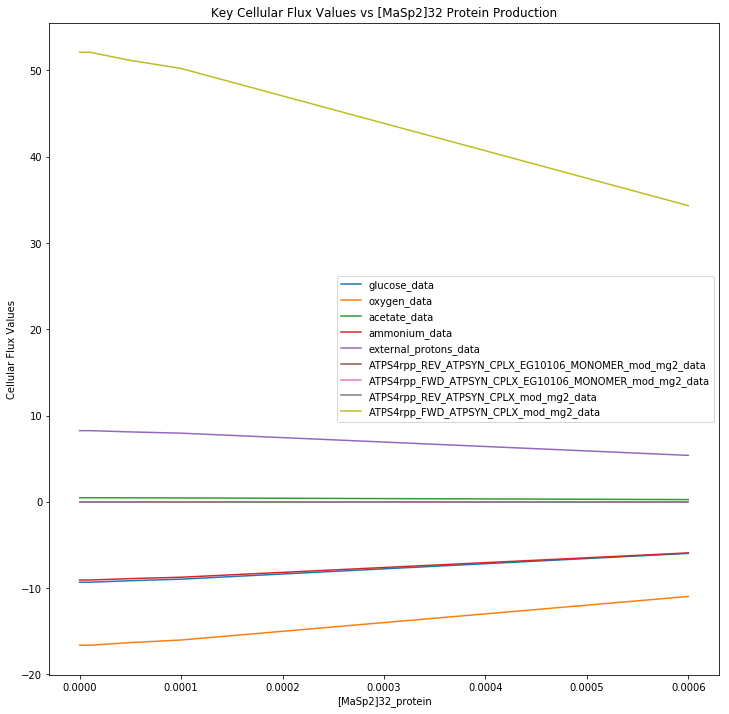

In [29]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, glucose_data, label = "glucose_data")
plt.plot(x, oxygen_data, label = "oxygen_data")
plt.plot(x, acetate_data, label = "acetate_data")
plt.plot(x, ammonium_data, label = "ammonium_data")

plt.plot(x, external_protons_data, label = "external_protons_data")
plt.plot(x, ATPS4rpp_REV_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data, label = "ATPS4rpp_REV_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data")
plt.plot(x, ATPS4rpp_FWD_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data, label = "ATPS4rpp_FWD_ATPSYN_CPLX_EG10106_MONOMER_mod_mg2_data")
plt.plot(x, ATPS4rpp_REV_ATPSYN_CPLX_mod_mg2_data, label = "ATPS4rpp_REV_ATPSYN_CPLX_mod_mg2_data")
plt.plot(x, ATPS4rpp_FWD_ATPSYN_CPLX_mod_mg2_data, label = "ATPS4rpp_FWD_ATPSYN_CPLX_mod_mg2_data")

# naming the x axis
plt.xlabel('[MaSp2]32_protein')
# naming the y axis
plt.ylabel('Cellular Flux Values')
  
# giving a title to my graph
plt.title('Key Cellular Flux Values vs [MaSp2]32 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

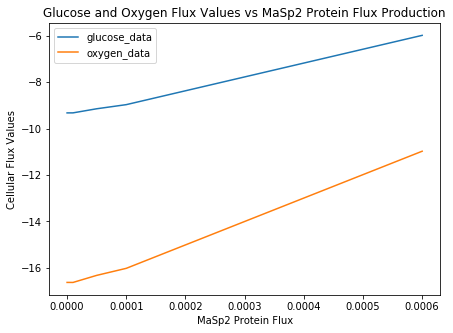

In [30]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(7,5))

# plotting the points 
plt.plot(x, glucose_data, label = "glucose_data")
plt.plot(x, oxygen_data, label = "oxygen_data")

# naming the x axis
plt.xlabel('MaSp2 Protein Flux')
# naming the y axis
plt.ylabel('Cellular Flux Values')
  
# giving a title to my graph
plt.title('Glucose and Oxygen Flux Values vs MaSp2 Protein Flux Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

In [49]:
glucose_data

[-9.32345814320908,
 -9.323347762502495,
 -9.322906239676152,
 -9.322354336143226,
 -9.145736298825561,
 -8.967773252056231,
 -5.981822915018402]

In [50]:
oxygen_data

[-16.62889701481881,
 -16.62902520931538,
 -16.629537987301653,
 -16.630178959784494,
 -16.325542512871305,
 -16.021996234154823,
 -10.975060340812606]

### Plot the growth-rate with respect to MaSp2 production

#### Plotting the flux of the individual tRNA charging reactions

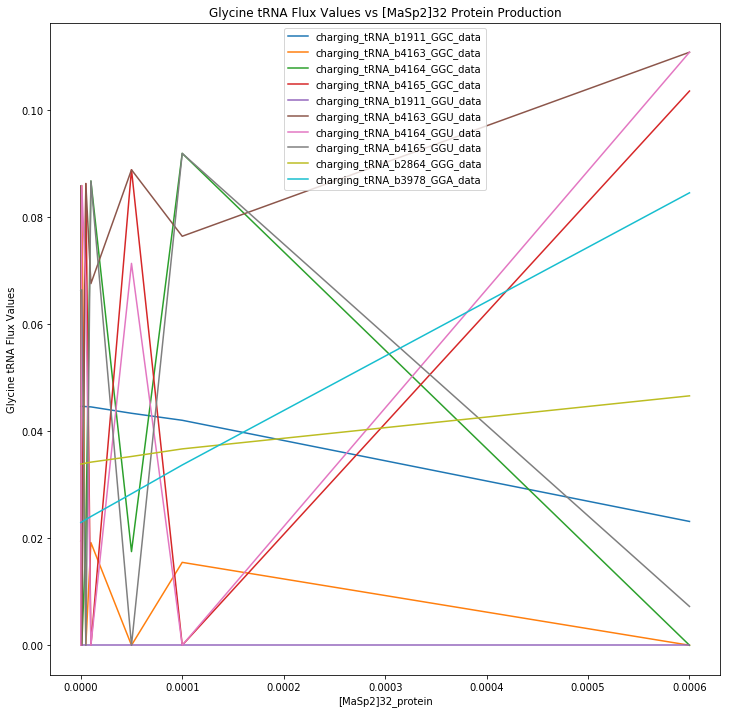

In [31]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, charging_tRNA_b1911_GGC_data, label = "charging_tRNA_b1911_GGC_data")
plt.plot(x, charging_tRNA_b4163_GGC_data, label = "charging_tRNA_b4163_GGC_data")
plt.plot(x, charging_tRNA_b4164_GGC_data, label = "charging_tRNA_b4164_GGC_data")
plt.plot(x, charging_tRNA_b4165_GGC_data, label = "charging_tRNA_b4165_GGC_data")

plt.plot(x, charging_tRNA_b1911_GGU_data, label = "charging_tRNA_b1911_GGU_data")
plt.plot(x, charging_tRNA_b4163_GGU_data, label = "charging_tRNA_b4163_GGU_data")
plt.plot(x, charging_tRNA_b4164_GGU_data, label = "charging_tRNA_b4164_GGU_data")
plt.plot(x, charging_tRNA_b4165_GGU_data, label = "charging_tRNA_b4165_GGU_data")

plt.plot(x, charging_tRNA_b2864_GGG_data, label = "charging_tRNA_b2864_GGG_data")
plt.plot(x, charging_tRNA_b3978_GGA_data, label = "charging_tRNA_b3978_GGA_data")

# naming the x axis
plt.xlabel('[MaSp2]32_protein')
# naming the y axis
plt.ylabel('Glycine tRNA Flux Values')
  
# giving a title to my graph
plt.title('Glycine tRNA Flux Values vs [MaSp2]32 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to the codon-related flux

GGC =  [0.15002752 0.15007874 0.15028364 0.15053976 0.14976764 0.14950535
 0.12675422]
GGU =  [0.1521538  0.15237817 0.15327564 0.15439748 0.1602813  0.16841335
 0.22898121]
GGG =  [0.0338643092219749, 0.0339008760574637, 0.03404714339941889, 0.03422997757686287, 0.035290191518641045, 0.03670734596708482, 0.04662473297113701]
GGA =  [0.0229336005179359, 0.02304692417953174, 0.023500218825915093, 0.02406683713389428, 0.02831815934835315, 0.033697302533411806, 0.08458163990917636]


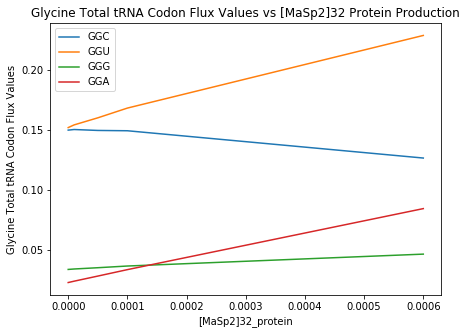

In [51]:
import numpy as np

GGC = [charging_tRNA_b1911_GGC_data, charging_tRNA_b4163_GGC_data, charging_tRNA_b4164_GGC_data, 
          charging_tRNA_b4165_GGC_data]
GGC = sum(map(np.array, GGC))
print('GGC = ', GGC)

GGU = [charging_tRNA_b1911_GGU_data, charging_tRNA_b4163_GGU_data, charging_tRNA_b4164_GGU_data,  
       charging_tRNA_b4165_GGU_data]
GGU = sum(map(np.array, GGU))
print('GGU = ', GGU)

GGG = charging_tRNA_b2864_GGG_data
print('GGG = ', GGG)

GGA = charging_tRNA_b3978_GGA_data
print('GGA = ', GGA)

# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(7,5))

# plotting the points 
plt.plot(x, GGC, label = "GGC")
plt.plot(x, GGU, label = "GGU")
plt.plot(x, GGG, label = "GGG")
plt.plot(x, GGA, label = "GGA")

# naming the x axis
plt.xlabel('[MaSp2]32_protein')
# naming the y axis
plt.ylabel('Glycine Total tRNA Codon Flux Values')
  
# giving a title to my graph
plt.title('Glycine Total tRNA Codon Flux Values vs [MaSp2]32 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to the charging reaction flux

b1911_data =  [0.04467434 0.0446629  0.04461712 0.04455991 0.04336718 0.04205629
 0.02314395]
b4163_data =  [0.08583566 0.08593134 0.08631405 0.08679244 0.08889392 0.09195414
 0.11086383]
b4164_data =  [0.08583566 0.08593134 0.08631405 0.08679244 0.08889392 0.09195414
 0.11086383]
b4165_data =  [0.08583566 0.08593134 0.08631405 0.08679244 0.08889392 0.09195414
 0.11086383]
b2864_data =  [0.0338643092219749, 0.0339008760574637, 0.03404714339941889, 0.03422997757686287, 0.035290191518641045, 0.03670734596708482, 0.04662473297113701]
b3978_data =  [0.0229336005179359, 0.02304692417953174, 0.023500218825915093, 0.02406683713389428, 0.02831815934835315, 0.033697302533411806, 0.08458163990917636]


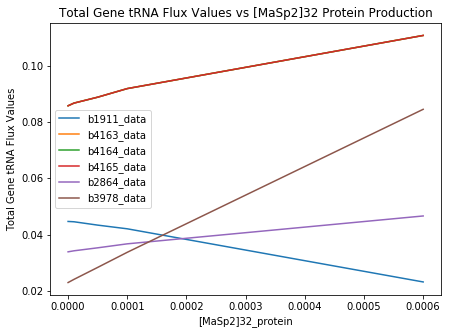

In [52]:
import numpy as np

b1911_data = [charging_tRNA_b1911_GGC_data, charging_tRNA_b1911_GGU_data]
b1911_data = sum(map(np.array, b1911_data))
print('b1911_data = ', b1911_data)

b4163_data = [charging_tRNA_b4163_GGC_data, charging_tRNA_b4163_GGU_data]
b4163_data = sum(map(np.array, b4163_data))
print('b4163_data = ', b4163_data)

b4164_data = [charging_tRNA_b4164_GGC_data, charging_tRNA_b4164_GGU_data]
b4164_data = sum(map(np.array, b4164_data))
print('b4164_data = ', b4164_data)

b4165_data = [charging_tRNA_b4165_GGC_data, charging_tRNA_b4165_GGU_data]
b4165_data = sum(map(np.array, b4165_data))
print('b4165_data = ', b4165_data)

b2864_data = charging_tRNA_b2864_GGG_data
print('b2864_data = ', b2864_data)

b3978_data = charging_tRNA_b3978_GGA_data
print('b3978_data = ', b3978_data)

# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(7,5))

# plotting the points 
plt.plot(x, b1911_data, label = "b1911_data")
plt.plot(x, b4163_data, label = "b4163_data")
plt.plot(x, b4164_data, label = "b4164_data")
plt.plot(x, b4165_data, label = "b4165_data")
plt.plot(x, b2864_data, label = "b2864_data")
plt.plot(x, b3978_data, label = "b3978_data")

# naming the x axis
plt.xlabel('[MaSp2]32_protein')
# naming the y axis
plt.ylabel('Total Gene tRNA Flux Values')
  
# giving a title to my graph
plt.title('Total Gene tRNA Flux Values vs [MaSp2]32 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

### Reactions that create charged tRNA metabolites for both Alanine

There are four different codons that can be used to create alanine tRNA. The metabolites associated with these alanine codons are

### Alanine tRNA Charged Metabolites
1. generic_tRNA_GCA_ala__L_c
- generic_tRNA_GCG_ala__L_c
- generic_tRNA_GCU_ala__L_c
- generic_tRNA_GCC_ala__L_c

### Alanine tRNA Charging Reactions
The reactions, based on codons, that create these charged tRNA metabolites are

##### GCA
1. charging_tRNA_b0203_GCA
- charging_tRNA_b3276_GCA
- charging_tRNA_b3853_GCA

##### GCG
1. charging_tRNA_b0203_GCG
- charging_tRNA_b3276_GCG
- charging_tRNA_b3853_GCG

##### GCU
1. charging_tRNA_b0203_GCU
- charging_tRNA_b3276_GCU
- charging_tRNA_b3853_GCU

##### GCC
1. charging_tRNA_b2396_GCC
- charging_tRNA_b2397_GCC

Note that there are five different reactions that create these alanine tRNA metabolites. Also note that there are three reactions that create the alanine tRNA for three of the codons.

#### Plotting the flux of the individual alanine tRNA charging reactions

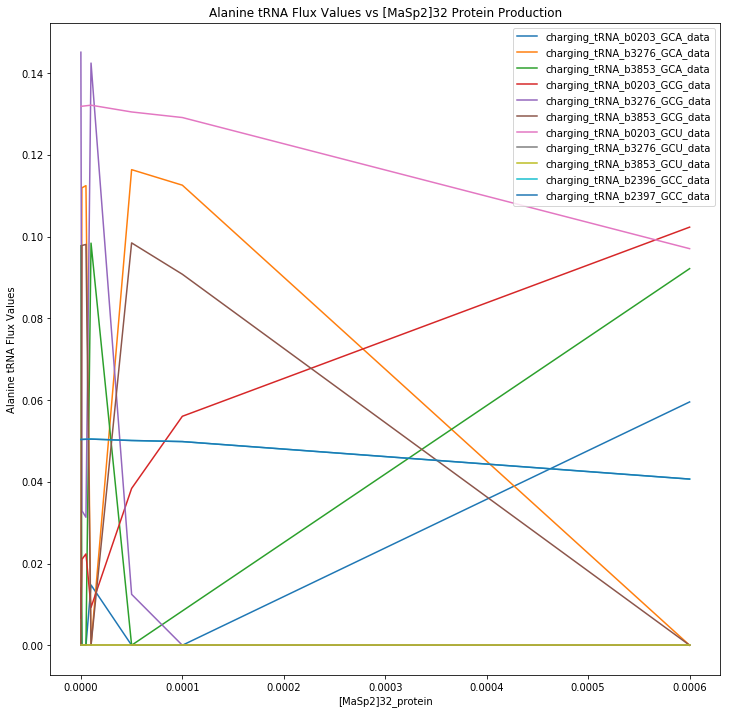

In [34]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, charging_tRNA_b0203_GCA_data, label = "charging_tRNA_b0203_GCA_data")
plt.plot(x, charging_tRNA_b3276_GCA_data, label = "charging_tRNA_b3276_GCA_data")
plt.plot(x, charging_tRNA_b3853_GCA_data, label = "charging_tRNA_b3853_GCA_data")

plt.plot(x, charging_tRNA_b0203_GCG_data, label = "charging_tRNA_b0203_GCG_data")
plt.plot(x, charging_tRNA_b3276_GCG_data, label = "charging_tRNA_b3276_GCG_data")
plt.plot(x, charging_tRNA_b3853_GCG_data, label = "charging_tRNA_b3853_GCG_data")

plt.plot(x, charging_tRNA_b0203_GCU_data, label = "charging_tRNA_b0203_GCU_data")
plt.plot(x, charging_tRNA_b3276_GCU_data, label = "charging_tRNA_b3276_GCU_data")
plt.plot(x, charging_tRNA_b3853_GCU_data, label = "charging_tRNA_b3853_GCU_data")

plt.plot(x, charging_tRNA_b2396_GCC_data, label = "charging_tRNA_b2396_GCC_data")
plt.plot(x, charging_tRNA_b2397_GCC_data, label = "charging_tRNA_b2397_GCC_data")

# naming the x axis
plt.xlabel('[MaSp2]32_protein')
# naming the y axis
plt.ylabel('Alanine tRNA Flux Values')
  
# giving a title to my graph
plt.title('Alanine tRNA Flux Values vs [MaSp2]32 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to the codon-related flux

GCA =  [0.11178709 0.11192209 0.1124621  0.11313711 0.11637562 0.12096355
 0.15169109]
GCG =  [0.15173974 0.15173826 0.15173235 0.15172496 0.14928087 0.14680419
 0.10230606]
GCU =  [0.13186192 0.13189043 0.13200446 0.132147   0.13049207 0.12912772
 0.0970396 ]
GCC =  [0.10070662 0.10072506 0.10079884 0.10089107 0.10019874 0.099672
 0.08131985]
total =  [0.49609537 0.49627584 0.49699775 0.49790013 0.49634729 0.49656746
 0.4323566 ]


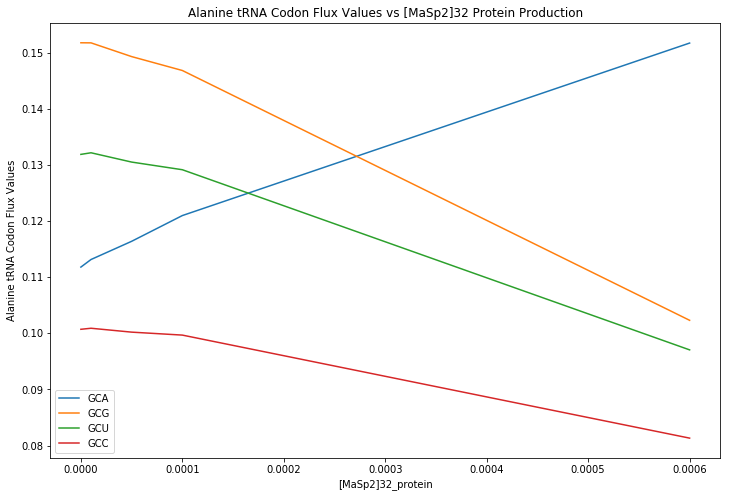

In [35]:
# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(12,8))

GCA = [charging_tRNA_b0203_GCA_data, charging_tRNA_b3276_GCA_data, charging_tRNA_b3853_GCA_data]
GCA = sum(map(np.array, GCA))
print('GCA = ', GCA)

GCG = [charging_tRNA_b0203_GCG_data, charging_tRNA_b3276_GCG_data, charging_tRNA_b3853_GCG_data]
GCG = sum(map(np.array, GCG))
print('GCG = ', GCG)

GCU = [charging_tRNA_b0203_GCU_data, charging_tRNA_b3276_GCU_data, charging_tRNA_b3853_GCU_data]
GCU = sum(map(np.array, GCU))
print('GCU = ', GCU)

GCC = [charging_tRNA_b2396_GCC_data, charging_tRNA_b2397_GCC_data]
GCC = sum(map(np.array, GCC))
print('GCC = ', GCC)

total = [GCA, GCG, GCU, GCC]
total = sum(map(np.array, total))
print('total = ', total)

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, GCA, label = "GCA")
plt.plot(x, GCG, label = "GCG")
plt.plot(x, GCU, label = "GCU")
plt.plot(x, GCC, label = "GCC")
#plt.plot(x, total, label = "Total")

# naming the x axis
plt.xlabel('[MaSp2]32_protein')
# naming the y axis
plt.ylabel('Alanine tRNA Codon Flux Values')
  
# giving a title to my graph
plt.title('Alanine tRNA Codon Flux Values vs [MaSp2]32 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to the reaction flux

b0203 =  [0.15252988 0.15289304 0.15434565 0.15616141 0.16886127 0.18515271
 0.25888246]
b3276 =  [0.14510823 0.1448428  0.14378108 0.14245392 0.12883737 0.11257359
 0.        ]
b3853 =  [0.09775063 0.09781494 0.09807218 0.09839374 0.09844992 0.09916916
 0.09215428]
b2396 =  [0.05035331 0.05036253 0.05039942 0.05044553 0.05009937 0.049836
 0.04065992]
b2397 =  [0.05035331 0.05036253 0.05039942 0.05044553 0.05009937 0.049836
 0.04065992]
total =  [0.49609537 0.49627584 0.49699775 0.49790013 0.49634729 0.49656746
 0.4323566 ]


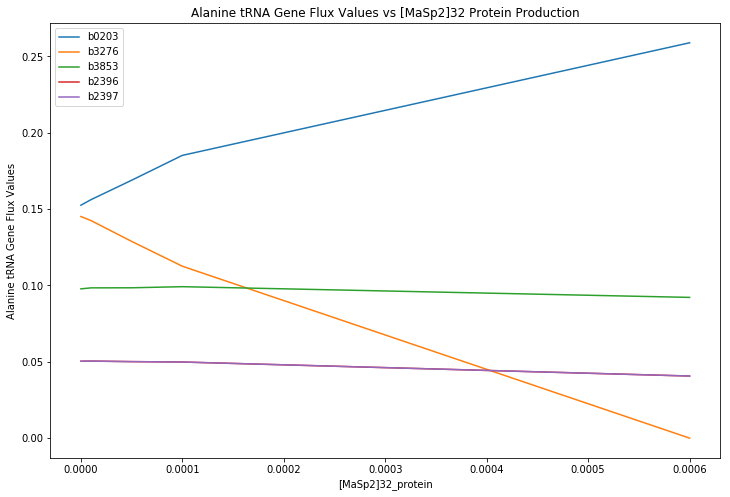

In [36]:
# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(12,8))

b0203 = [charging_tRNA_b0203_GCA_data, charging_tRNA_b0203_GCG_data, charging_tRNA_b0203_GCU_data]
b0203 = sum(map(np.array, b0203))
print('b0203 = ', b0203)

b3276 = [charging_tRNA_b3276_GCA_data, charging_tRNA_b3276_GCG_data, charging_tRNA_b3276_GCU_data]
b3276 = sum(map(np.array, b3276))
print('b3276 = ', b3276)

b3853 = [charging_tRNA_b3853_GCA_data, charging_tRNA_b3853_GCG_data, charging_tRNA_b3853_GCU_data]
b3853 = sum(map(np.array, b3853))
print('b3853 = ', b3853)

b2396 = [charging_tRNA_b2396_GCC_data]
b2396 = sum(map(np.array, b2396))
print('b2396 = ', b2396)

b2397 = [charging_tRNA_b2397_GCC_data]
b2397 = sum(map(np.array, b2397))
print('b2397 = ', b2397)

total = [b0203, b3276, b3853, b2396,b2397]
total = sum(map(np.array, total))
print('total = ', total)

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, b0203, label = "b0203")
plt.plot(x, b3276, label = "b3276")
plt.plot(x, b3853, label = "b3853")
plt.plot(x, b2396, label = "b2396")
plt.plot(x, b2397, label = "b2397")
#plt.plot(x, total, label = "total")

# naming the x axis
plt.xlabel('[MaSp2]32_protein')
# naming the y axis
plt.ylabel('Alanine tRNA Gene Flux Values')
  
# giving a title to my graph
plt.title('Alanine tRNA Gene Flux Values vs [MaSp2]32 Protein Production')
  
# function to show the plot
plt.legend()
#plt.yscale('log')
plt.show()

#### Plot the transcription, translation, and ribosome flux with respect to MaSp2 production

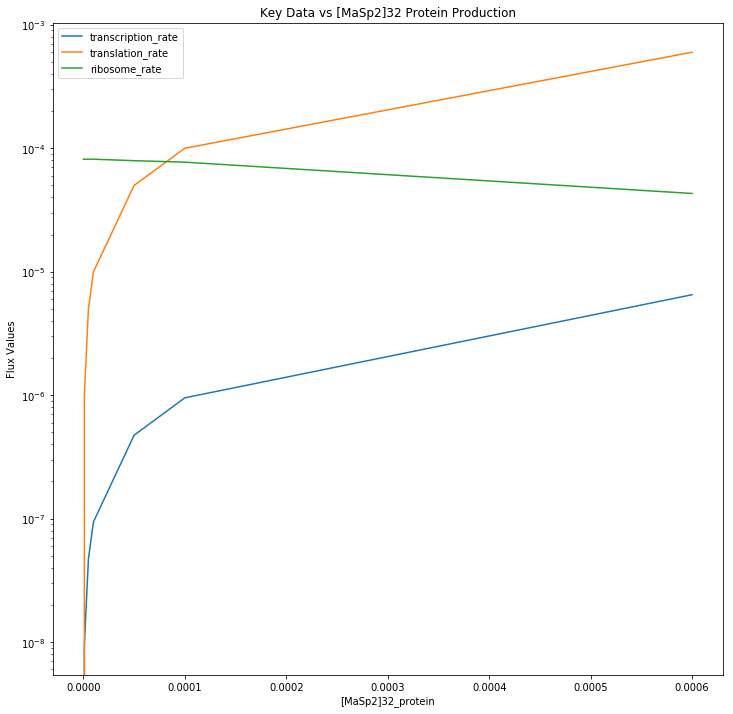

In [37]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2_protein
# corresponding y axis values

plt.figure(figsize=(12,12))

# plotting the points 
#plt.plot(x, growth_rate, label = "growth_rate")
plt.plot(x, transcription_rate, label = "transcription_rate")
plt.plot(x, translation_rate, label = "translation_rate")
plt.plot(x, ribosome_rate, label = "ribosome_rate")
#plt.plot(x, ribosome_shadow_price, label = "ribosome_shadow_price")

# naming the x axis
plt.xlabel('[MaSp2]32_protein')
# naming the y axis
plt.ylabel('Flux Values')
  
# giving a title to my graph
plt.title('Key Data vs [MaSp2]32 Protein Production')
  
# function to show the plot
plt.legend()
plt.yscale('log')
plt.show()

#### Plot the growth-rate with respect to MaSp2 production

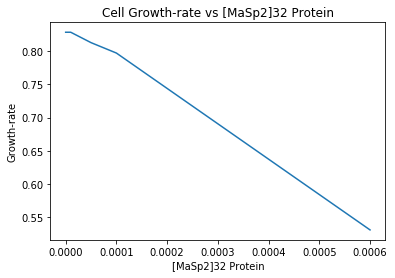

In [38]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp2_protein
# corresponding y axis values
y = growth_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 Protein')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs [MaSp2]32 Protein')
  
# function to show the plot
plt.show()

#### Plot the transcription flux with respect to MaSp2 production

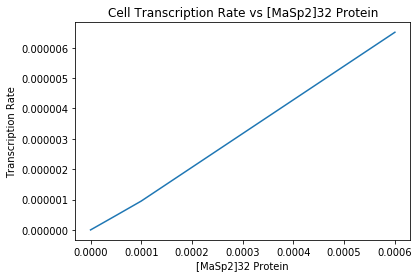

In [39]:
# x axis values
x = MaSp2_protein
# corresponding y axis values
y = transcription_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 Protein')
# naming the y axis
plt.ylabel('Transcription Rate')
  
# giving a title to my graph
plt.title('Cell Transcription Rate vs [MaSp2]32 Protein')
  
# function to show the plot
plt.show()

#### Plot the translation flux with respect to MaSp2 production

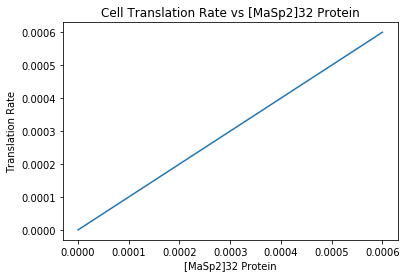

In [40]:
# x axis values
x = MaSp2_protein
# corresponding y axis values
y = translation_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 Protein')
# naming the y axis
plt.ylabel('Translation Rate')
  
# giving a title to my graph
plt.title('Cell Translation Rate vs [MaSp2]32 Protein')
  
# function to show the plot
plt.show()

#### Plot the ribosome flux with respect to MaSp2 production

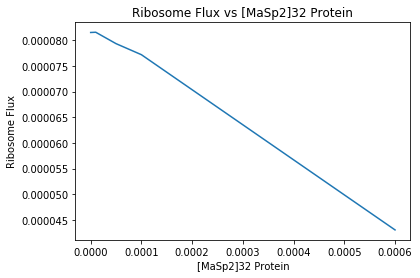

In [41]:
# x axis values
x = MaSp2_protein
# corresponding y axis values
y = ribosome_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 Protein')
# naming the y axis
plt.ylabel('Ribosome Flux')
  
# giving a title to my graph
plt.title('Ribosome Flux vs [MaSp2]32 Protein')
  
# function to show the plot
plt.show()

#### Plot the ribosome shadow prices with respect to MaSp2 production

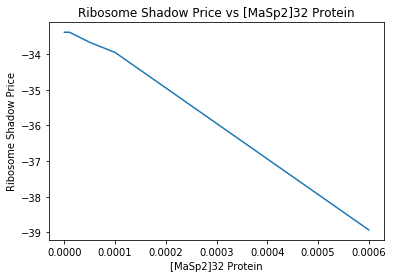

In [42]:
# x axis values
x = MaSp2_protein
# corresponding y axis values
y = ribosome_shadow_price
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 Protein')
# naming the y axis
plt.ylabel('Ribosome Shadow Price')
  
# giving a title to my graph
plt.title('Ribosome Shadow Price vs [MaSp2]32 Protein')
  
# function to show the plot
plt.show()

#### Plot the secreted acetate flux with respect to MaSp2 production

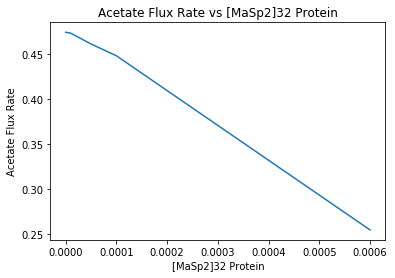

In [43]:
# x axis values
x = MaSp2_protein
# corresponding y axis values
y = acetate_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 Protein')
# naming the y axis
plt.ylabel('Acetate Flux Rate')
  
# giving a title to my graph
plt.title('Acetate Flux Rate vs [MaSp2]32 Protein')
  
# function to show the plot
plt.show()

#### Plot the ATP production flux with respect to MaSp2 production

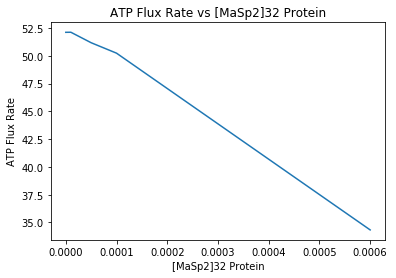

In [44]:
# x axis values
x = MaSp2_protein
# corresponding y axis values
y = ATP_flux
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('[MaSp2]32 Protein')
# naming the y axis
plt.ylabel('ATP Flux Rate')
  
# giving a title to my graph
plt.title('ATP Flux Rate vs [MaSp2]32 Protein')
  
# function to show the plot
plt.show()

In [45]:
show_escher_map(me).display_in_notebook()

In [46]:
print('transcription_TU_MaSp2 =', me.reactions.get_by_id('transcription_TU_MaSp2').x)
print('formation_RNAP70-CPLX =', me.reactions.get_by_id('formation_RNAP70-CPLX').x)

transcription_TU_MaSp2 = 6.508913055757281e-06
formation_RNAP70-CPLX = 2.0516940925354205e-06


In [47]:
me.metabolites.protein_MaSp2.reactions

frozenset({<MEReaction DM_protein_MaSp2 at 0x7f9525c4c9e8>,
           <TranslationReaction translation_MaSp2 at 0x7f9525caf208>})

In [48]:
me.reactions.translation_MaSp2.x

0.0006